In [3]:
# moduleのインポート
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans

<ipython-input-33-426c20b9f477>:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-33-426c20b9f477>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-33-426c20b9f477>:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipy

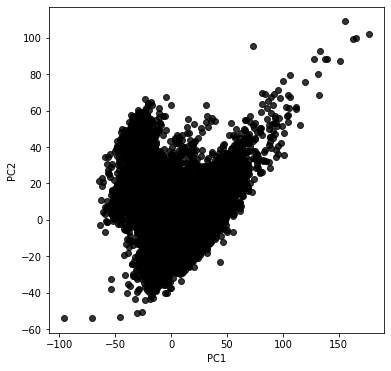

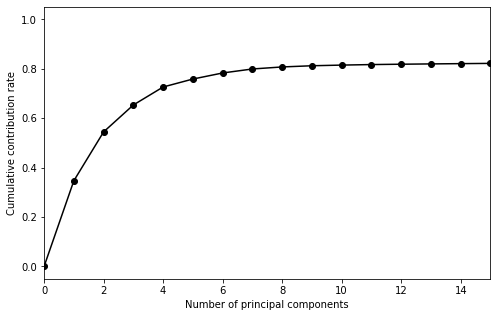

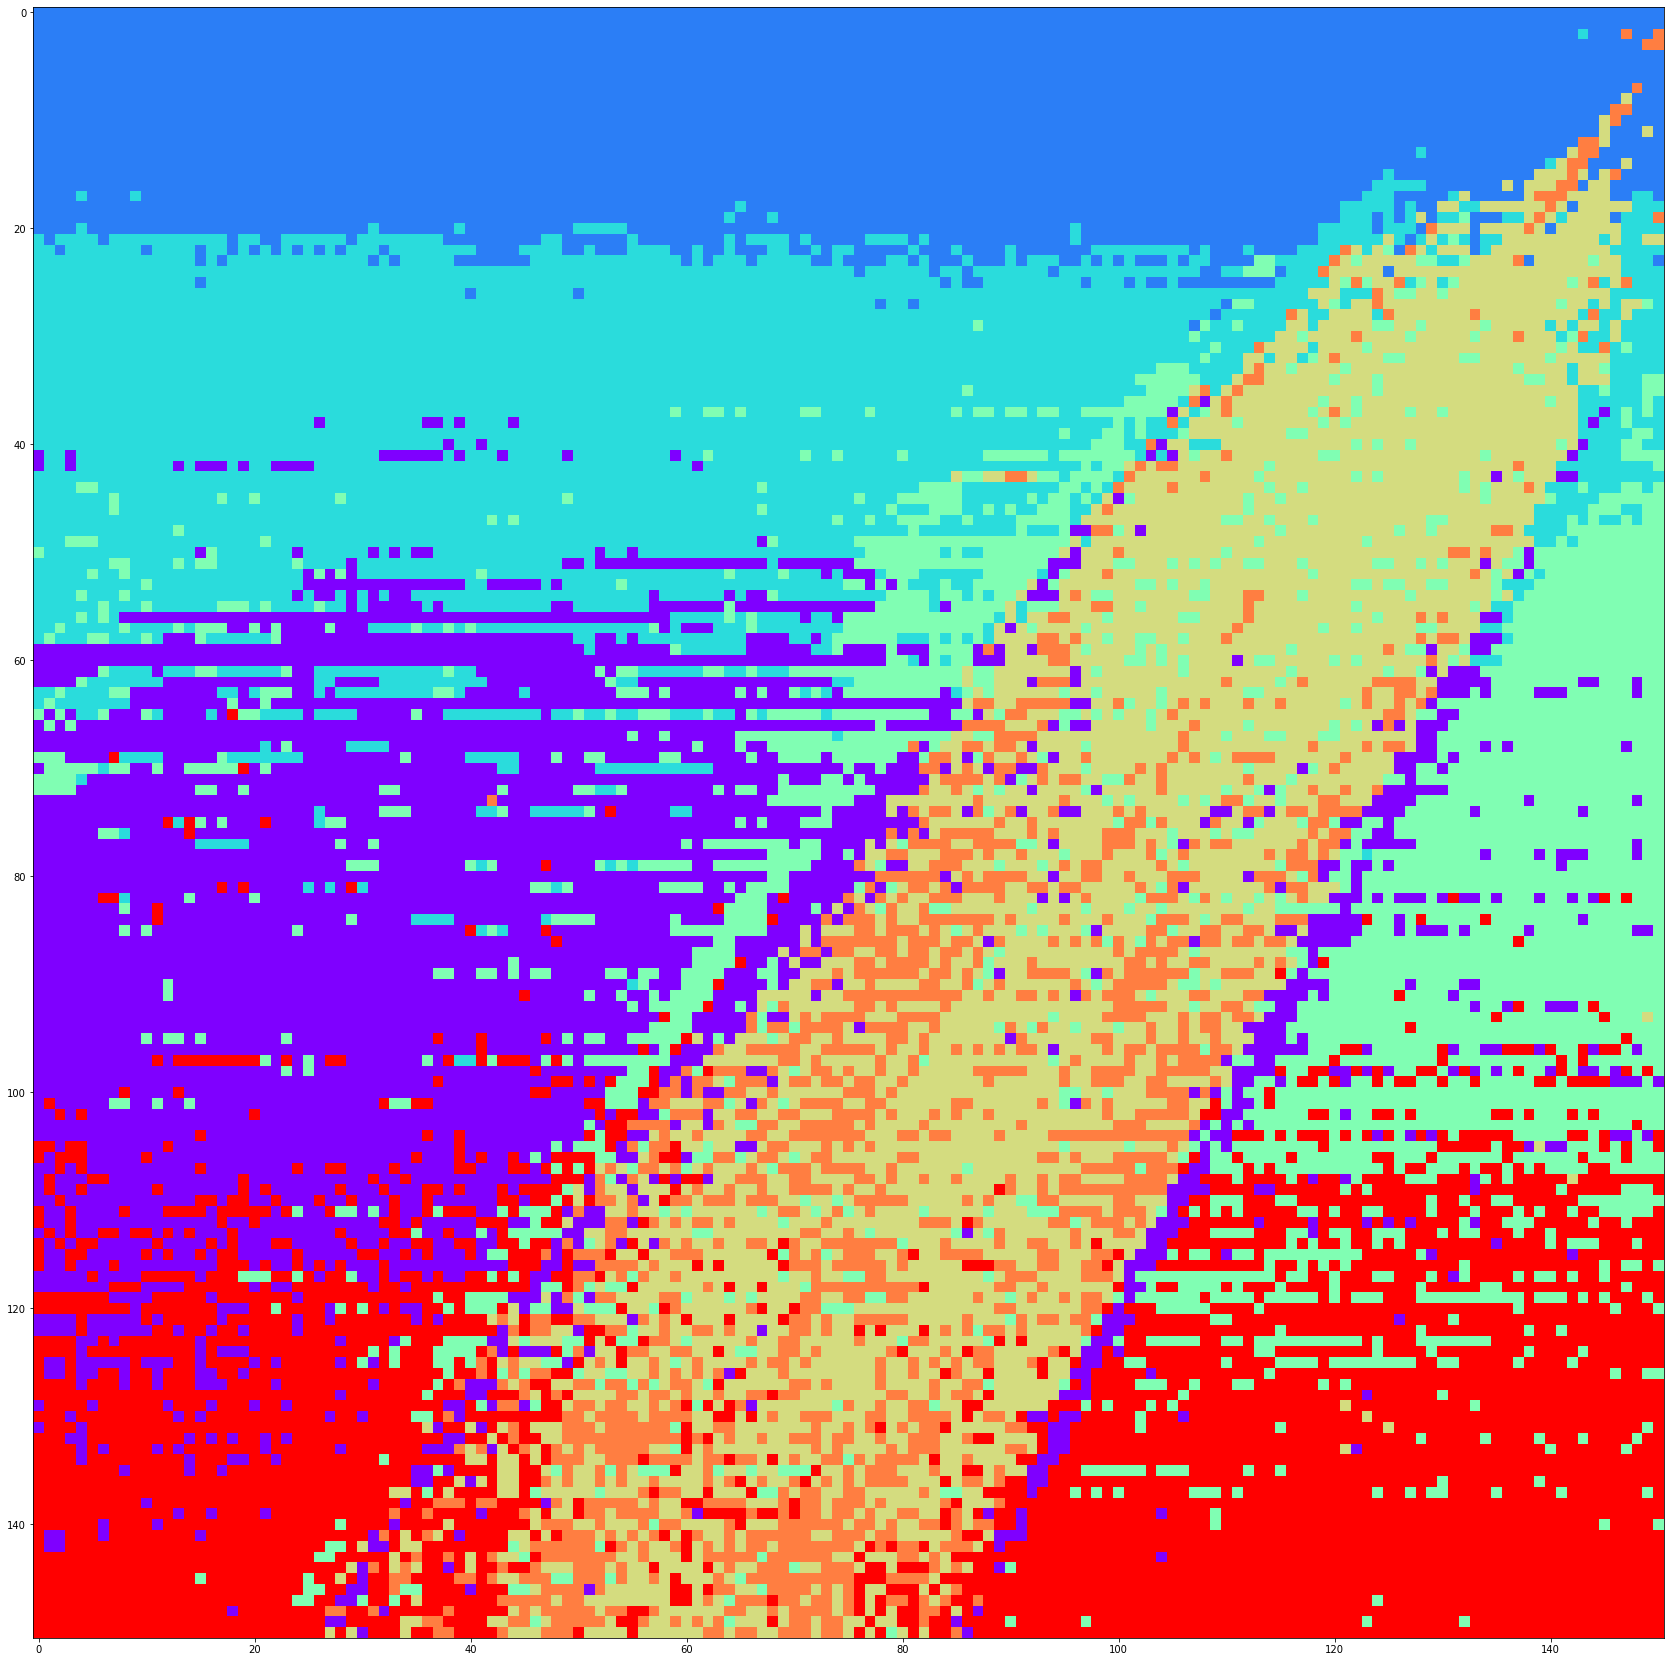

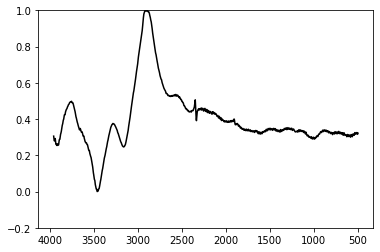

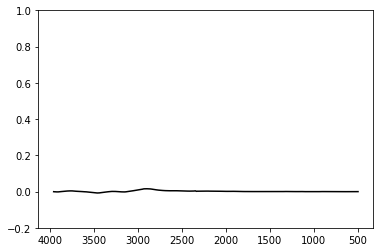

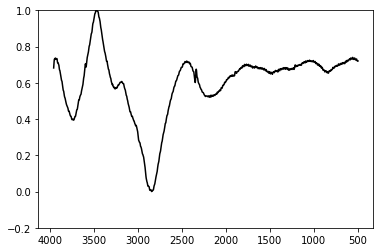

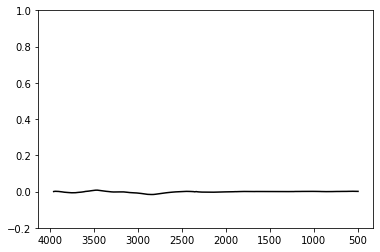

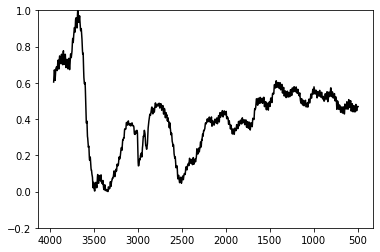

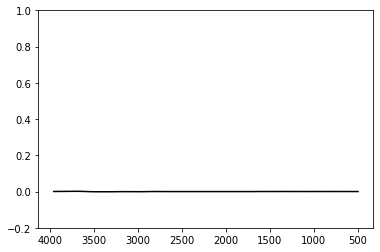

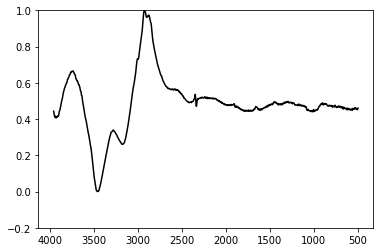

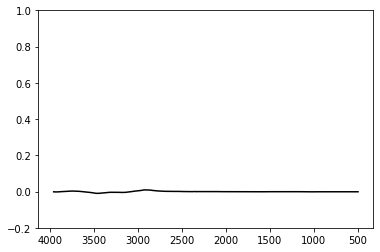

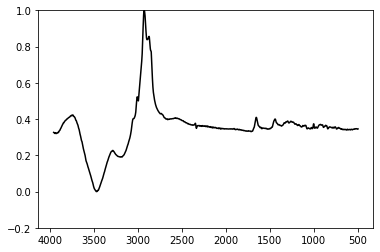

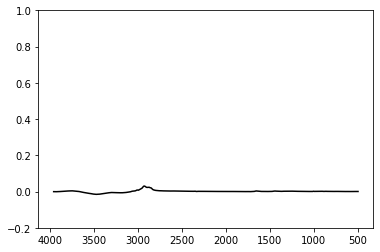

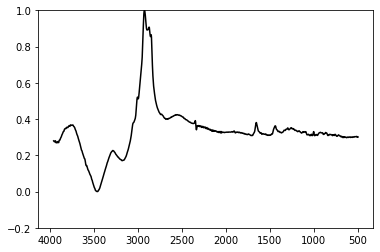

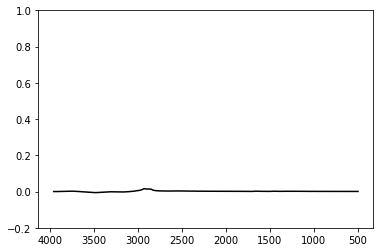

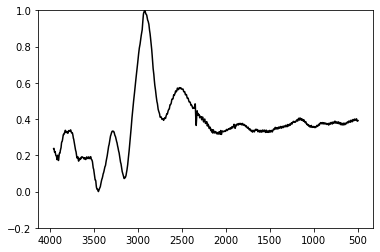

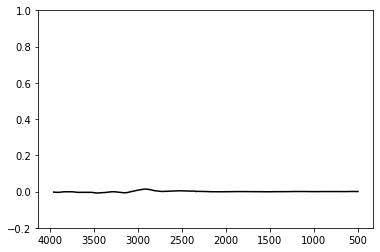

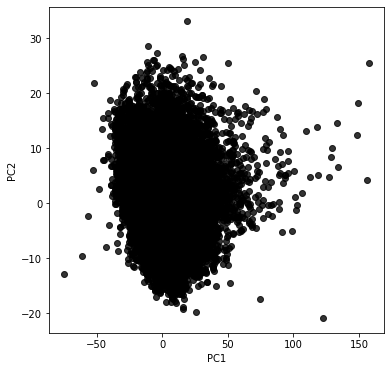

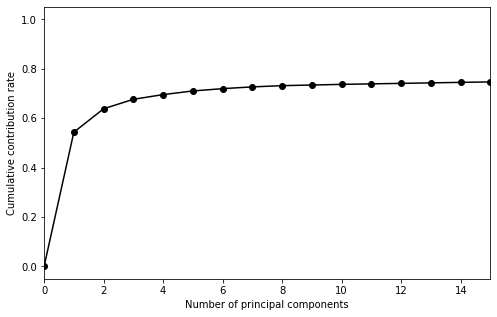

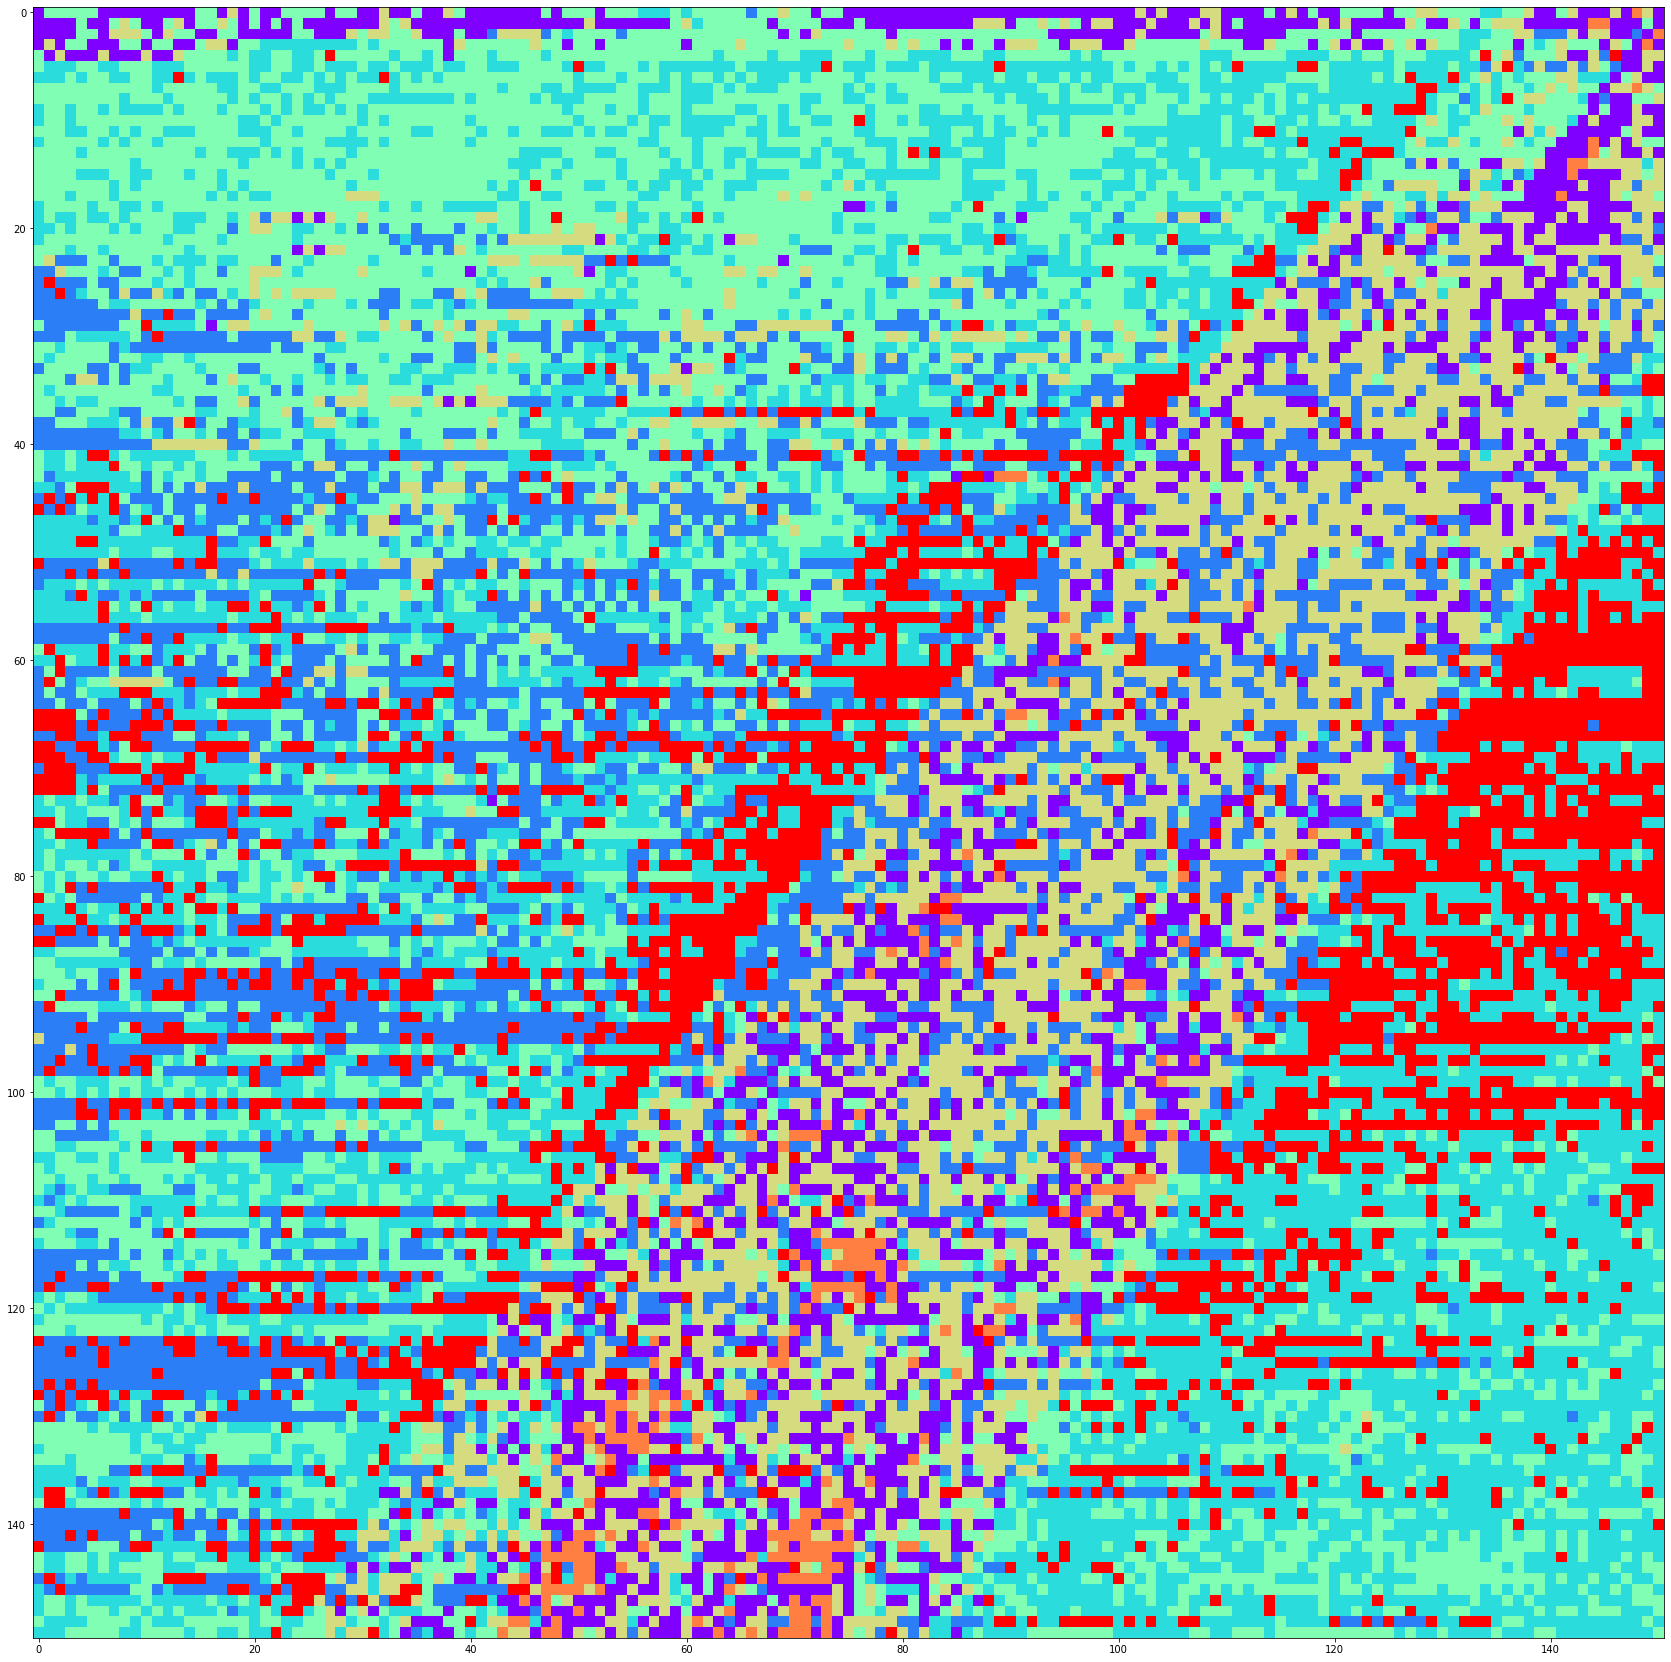

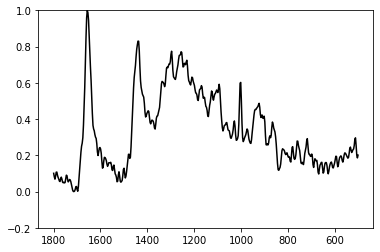

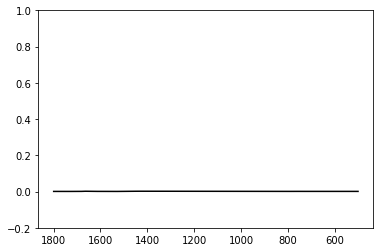

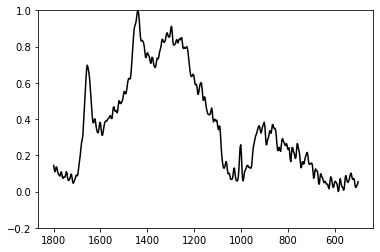

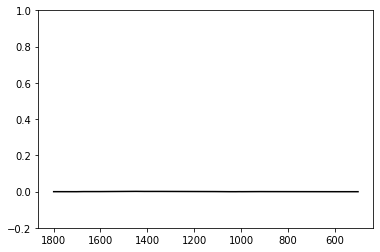

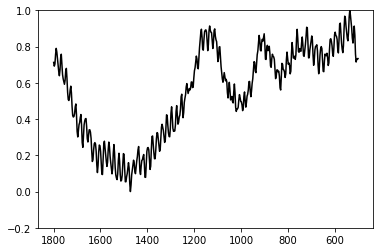

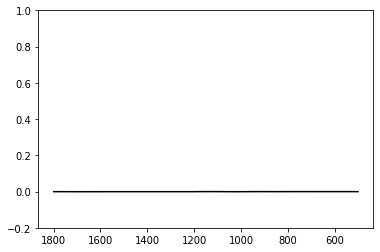

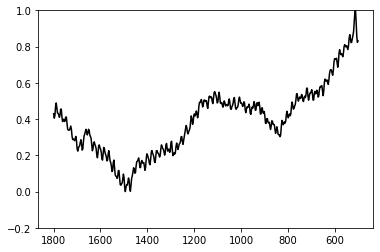

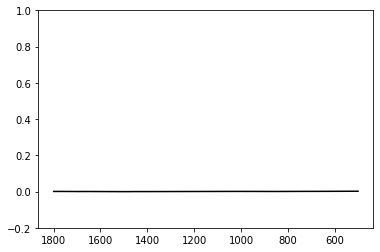

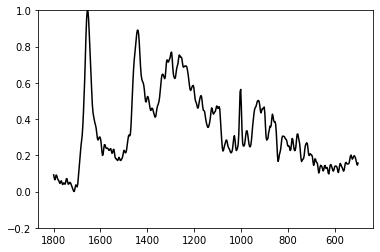

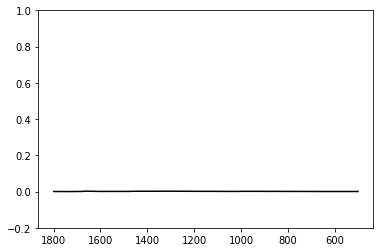

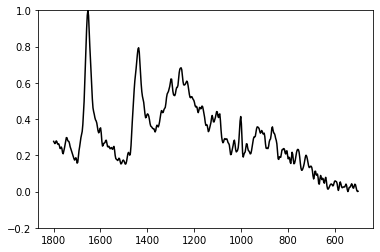

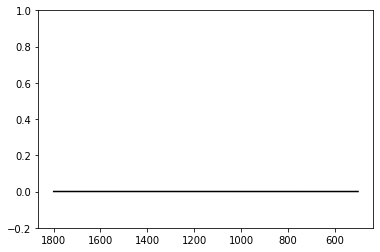

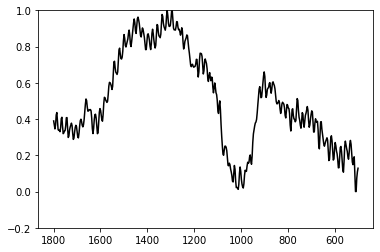

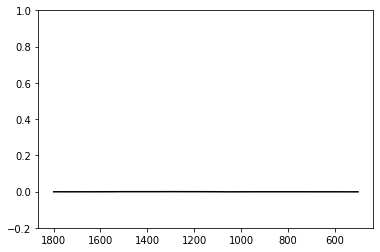

In [33]:
# データのパス
data_path = "/content/drive/MyDrive/miyazaki/python_analysis/MCR_ALS/Data/20220608SLPw/imchi3_2d.csv"
# 横軸のパス
axis_path = "/content/drive/MyDrive/miyazaki/python_analysis/MCR_ALS/Data/20220608SLPw/re_ramanshift2.csv"

# PCA後のデータをいくつのクラスターに分けるか
cluster_num = 7
# データの縦幅
x = 151
# データの横幅
y = 151
# 詳細に解析する波数範囲 (指紋領域用にしています)
subrange = (500, 1800)

def normalization(data_array):
    """
    normalize the data array within 0~255
    :param data_array: numpy array
    :return: data_array: numpy array (overwrite)
    """
    amin = np.amin(data_array)
    amax = np.amax(data_array)
    scale = 255.0 / (amax - amin)
    data_array = data_array - amin
    data_array = data_array * scale
    data_array = np.uint8(data_array)
    return data_array

def PCA_analysis(data, x_axis, flag):
    # data normalization
    norm_data = data.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    pca = PCA()
    pca.fit(norm_data)
    feature = pca.transform(norm_data)
    data_PCA = pd.DataFrame(feature,
                            columns=["PC{}".format(x + 1) for x in range(len(norm_data.columns))])

    Spectrum = []

    # make graph for PC scatter
    os.makedirs("./results/figures", exist_ok=True)
    plt.figure(figsize=(6, 6))
    plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, color="black")
    plt.grid()
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(False)
    plt.savefig("./results/figures/PCA_scatter_{}.png".format(flag), transparent=True)

    # make graph for CDF
    plt.figure(figsize=(8, 5))
    pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(norm_data.columns))])
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o",
             color="black")
    plt.xlabel("Number of principal components")
    plt.ylabel("Cumulative contribution rate")
    plt.grid()
    plt.xlim(0, 15)
    plt.grid(False)
    plt.savefig("./results/figures/PCA_CDF_{}.png".format(flag), transparent=True, bbox_inches="tight", pad_inches=0.1)

    # clustering and
    plt.figure(figsize=(30, 30))
    extracted_df = data_PCA
    cust_array = extracted_df.to_numpy()
    cust_array = cust_array
    pred = KMeans(n_clusters=cluster_num).fit_predict(cust_array)
    pred_image = np.reshape(pred, [x, y])
    plt.imshow(pred_image, cmap="rainbow")
    plt.savefig('./results/figures/clustered_img_{}.png'.format(flag))
    # plt.imsave('./results/figures/clustered_img_{}.png'.format(flag), pred_image)

    # class differentiation
    os.makedirs("./results/spectrum_{}".format(flag), exist_ok=True)
    os.makedirs("./results/figures/Class_images_{}".format(flag), exist_ok=True)
    Class_list = []
    for i in range(cluster_num):
        Class_list.append(np.where(pred != i, 0, 1))
        plt.imsave("./results/figures/Class_images_{0}/Class{1}.png".format(flag, i),
                   np.reshape(np.where(pred != i, 0, 1), [x, y]))

    for i in range(cluster_num):
        fig, ax = plt.subplots()
        Class_data = data.T * Class_list[i]
        Class_data = np.mean(Class_data.T.values, axis=0)
        Class_min = np.min(Class_data)
        Class_max = np.max(Class_data)
        norm_Class_data = (Class_data - Class_min) / (Class_max - Class_min)
        ax.set_ylim([-0.2, 1])
        ax.grid(False)
        ax.invert_xaxis()
        ax.plot(x_axis, norm_Class_data, color="black")
        plt.savefig("./results/spectrum_{0}/norm_Class_{1}.png".format(flag, i),
                    transparent=True, bbox_inches="tight", pad_inches=0.1)

        fig, ax = plt.subplots()
        ax.set_ylim([-0.2, 1])
        ax.grid(False)
        ax.invert_xaxis()
        ax.plot(x_axis, Class_data, color="black")
        plt.savefig("./results/spectrum_{0}/Class_{1}.png".format(flag, i),
                    transparent=True, bbox_inches="tight", pad_inches=0.1)

        pd.DataFrame(Class_data).to_csv("./results/spectrum_{0}/Class_{1}.csv".format(flag, i))
        Spectrum.append(Class_data)
    return Spectrum

def execute_analysis(data_path, axis_path):
    os.chdir(os.path.dirname(data_path))
    # all range analysis
    data = pd.read_csv(data_path, header=None).T[0:x * y]
    x_axis = np.loadtxt(axis_path)
    Spectrum = PCA_analysis(data, x_axis, flag="full")
    #Entropy_analysis(data, x_axis, flag="full")

    # subrange analysis
    subrange_axis = x_axis[np.where((x_axis > subrange[0]) & (x_axis < subrange[1]))]
    subrange_data = data.T.iloc[np.where((x_axis > subrange[0]) & (x_axis < subrange[1]))].T
    PCA_analysis(subrange_data, subrange_axis, flag="subrange")
    #Entropy_analysis(data, x_axis, flag="subrange")

    return Spectrum


Spectrum = execute_analysis(data_path, axis_path)

In [34]:
Spectrum = np.array(Spectrum)
S = pd.DataFrame(Spectrum)

In [35]:
#S = S.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
S.values.shape

(7, 1280)

In [36]:
from pymcr.mcr import McrAR
from pymcr.regressors import NNLS, OLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

# Note constraint order matters
mcrar = McrAR(c_regr=NNLS(), st_regr=NNLS(), c_constraints=[], st_constraints=[])


In [37]:
D = pd.read_csv(data_path, header=None).T[0:x * y]
#D = D.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
D = D.values

In [38]:
D.shape

(22801, 1280)

In [39]:
mcrar.fit(D, ST=Spectrum, verbose=True)

Iter: 1 (C)	mse: 1.1112e-04


DEBUG:pymcr.mcr:Iter: 1 (C)	mse: 1.1112e-04


Error increased above fractional tol_increase (ST iter). Exiting


INFO:pymcr.mcr:Error increased above fractional tol_increase (ST iter). Exiting


In [40]:
import matplotlib.pyplot as plt

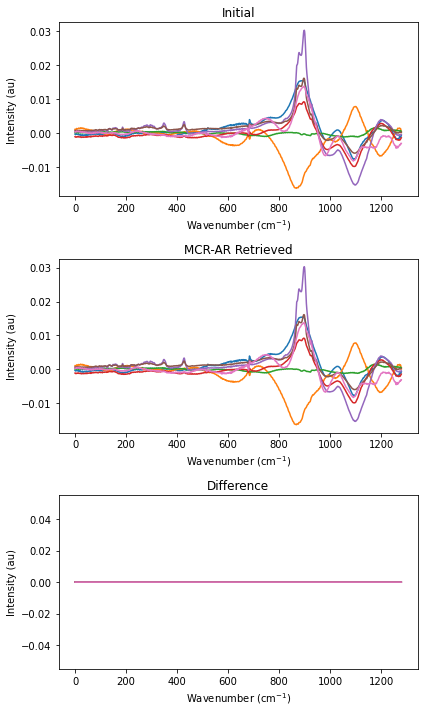

In [41]:
plt.figure(figsize=(6,10))
plt.subplot(311)
plt.plot(Spectrum.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial')

plt.subplot(312)
plt.plot(mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(313)
plt.plot(Spectrum.T - mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()


In [42]:
x = 
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.imshow(mcrar.C_opt_[:,0].reshape(x,y))
plt.subplot(332)
plt.imshow(mcrar.C_opt_[:,2].reshape(x,y))
plt.subplot(333)
plt.imshow(mcrar.C_opt_[:,1].reshape(x,y))
plt.subplot(334)
plt.imshow(mcrar.C_opt_[:,3].reshape(x,y))
plt.subplot(335)
plt.imshow(mcrar.C_opt_[:,4].reshape(x,y))
plt.subplot(336)
plt.imshow(mcrar.C_opt_[:,5].reshape(x,y))
plt.subplot(337)
plt.imshow(mcrar.C_opt_[:,6].reshape(x,y))
plt.savefig("./result_imgs")
"""plt.subplot(338)
plt.imshow(mcrar.C_opt_[:,7].reshape(201,201))
plt.subplot(339)
plt.imshow(mcrar.C_opt_[:,8].reshape(201,201))"""

SyntaxError: ignored

In [ ]:
plt.imshow(mcrar.C_opt_[:,0].reshape(201,201))


In [ ]:
plt.plot(mcrar.ST_opt_.T[:,0])
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

In [ ]:
plt.plot(mcrar.ST_opt_.T[:,1])
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')